# Source
https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

* Prepare photo and text data for training a deep learning model
* Design and train a deep learning caption generation model
* Evaluate a train caption generation model and use it to caption entirely new photographs

# Flickr8K
* http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
* http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip

* **Flicker8k_Dataset**: Contains 8092 photographs in JPEG format
* **Flickr8k_text**: Contains a number of files containing different sources of descriptions for the photographs

# Image Feature Extraction
* Oxford Visual Geometry Group, or VGG

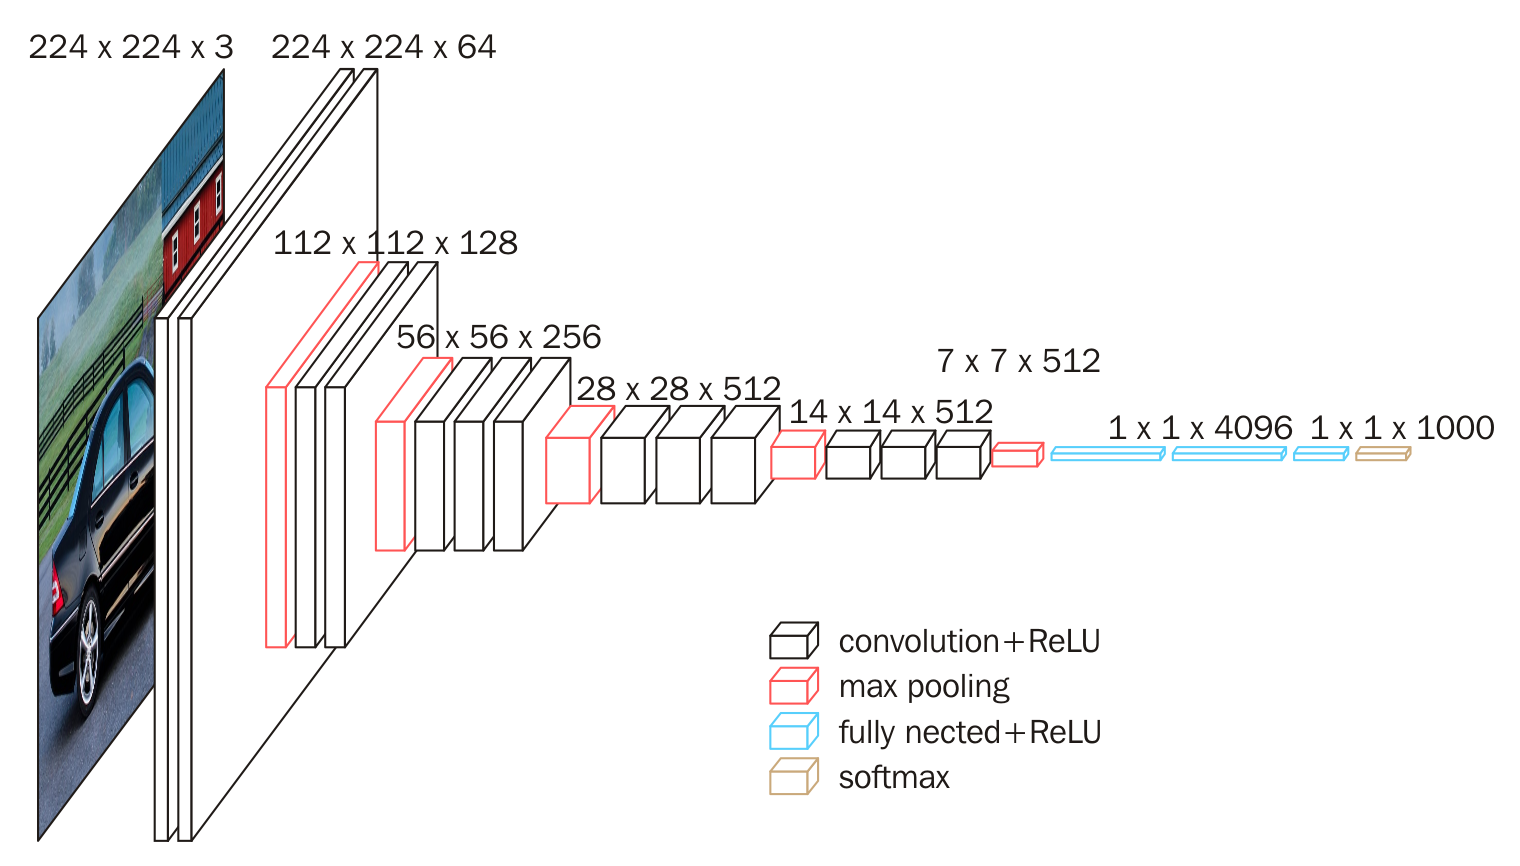

* **Keras provides this pre-trained model (See Keras Applications)** *Note, the first time you use this model, Keras will download the model weights from the Internet, which are about 500 Megabytes*
* For better performance the photo features are pre-computed
* These pre-computed features are interpretation of photos in the dataset
* The image features are a 1-dimensional 4,096 element vector extracted from before softmax layer

In [1]:
from pickle import dump
from FeatureExtractor import extract_features
# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Using TensorFlow backend.


# Prepare Text Data
* Load the file containing all of the descriptions

In [2]:
from DocUtils import load_doc
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

* Map photo identifiers to descriptions. Each photo identifier maps to a list of one or more textual descriptions

In [3]:
from DocUtils import load_descriptions
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


#### Clean the description text (reduce the size of the vocabulary)
* Convert all words to lowercase
* Remove all punctuation
* Remove all words that are one character or less in length (e.g. ‘a’)
* Remove all words with numbers in them

In [4]:
from DocUtils import clean_descriptions
# clean descriptions
clean_descriptions(descriptions)

* Create vocabulary

In [5]:
from DocUtils import to_vocabulary
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


* Save descriptions

In [6]:
from DocUtils import save_descriptions
# save to file
save_descriptions(descriptions, 'descriptions.txt')

# Develop Deep Learning Model
* Loading Data

In [7]:
from DataUtils import load_set
from DataUtils import load_clean_descriptions
from DataUtils import load_photo_features
from DataUtils import create_tokenizer
from DataUtils import max_length


# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


## Define Model

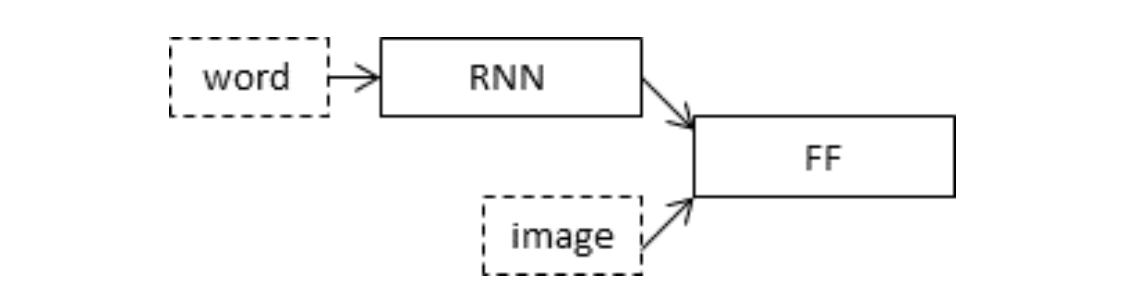

* **Photo Feature Extractor**. This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
* **Sequence Processor**. This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.
* **Decoder (for lack of a better name)**. Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction.

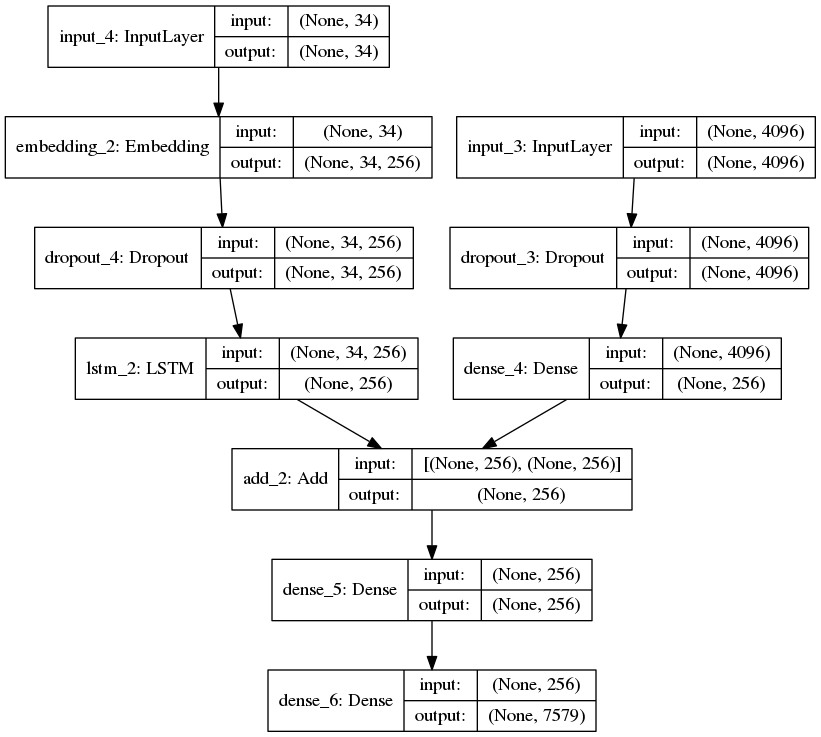


In [8]:
from Model import define_model
# define the model
model = define_model(vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

## Train Model

In [10]:
from DataUtils import data_generator
# train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('models/model_' + str(i) + '.h5')

Epoch 1/1
6000/6000 [==============================] - 1336s 223ms/step - loss: 4.6604


## Evaluate Model

In [1]:
from DataUtils import load_set
from DataUtils import load_clean_descriptions
from DataUtils import create_tokenizer
from DataUtils import max_length
from DataUtils import load_photo_features
from Model import evaluate_model
from keras.models import load_model
# prepare tokenizer on train set

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = 'models/model_16.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Using TensorFlow backend.


ModuleNotFoundError: No module named 'nltk'

## Generate New Captions

In [1]:
from pickle import dump
from DataUtils import load_set
from DataUtils import load_clean_descriptions
from DataUtils import create_tokenizer
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Using TensorFlow backend.


Dataset: 6000
Descriptions: train=6000


In [2]:
from pickle import load
from keras.models import load_model
from FeatureExtractor import extract_feature
from DataUtils import generate_desc
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('models/model_16.h5')
# load and prepare the photograph
photo = extract_feature('images/example.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq dog is running through the water endseq
